In [73]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from performance_profile import BASE_WORKLOADS, get_workloads_time_to_target
from plotting_utils import clean_results, read_data_from_logs

In [2]:
SELF_TUNING = False

log_path = "../../submissions_algorithms_v0.5/logs/algoperf_scoring_v05/"
if SELF_TUNING:
    log_path = os.path.join(log_path, "self_tuning")
else:
    log_path = os.path.join(log_path, "external_tuning")

full_results = read_data_from_logs(log_path)
clean_results_dict = clean_results(full_results, SELF_TUNING)

Reading data for submission: shampoo_submission
['ogbg_pytorch', 'librispeech_conformer_pytorch', 'fastmri_tanh_pytorch', 'ogbg_model_size_pytorch', 'criteo1tb_pytorch', 'librispeech_conformer_layernorm_pytorch', 'imagenet_vit_pytorch', 'wmt_pytorch', 'librispeech_deepspeech_pytorch', 'imagenet_resnet_pytorch', 'criteo1tb_embed_init_pytorch', 'fastmri_pytorch', 'imagenet_resnet_large_bn_init_pytorch', 'wmt_glu_tanh_pytorch']
['ogbg_pytorch', 'librispeech_conformer_pytorch', 'fastmri_tanh_pytorch', 'ogbg_model_size_pytorch', 'criteo1tb_pytorch', 'librispeech_conformer_layernorm_pytorch', 'imagenet_vit_pytorch', 'wmt_pytorch', 'librispeech_deepspeech_pytorch', 'imagenet_resnet_pytorch', 'criteo1tb_embed_init_pytorch', 'fastmri_pytorch', 'imagenet_resnet_large_bn_init_pytorch', 'wmt_glu_tanh_pytorch']
['ogbg_pytorch', 'librispeech_conformer_pytorch', 'fastmri_tanh_pytorch', 'ogbg_model_size_pytorch', 'criteo1tb_pytorch', 'librispeech_conformer_layernorm_pytorch', 'imagenet_vit_pytorch', '

2025-01-20 12:35:46.014860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [35]:
# Stack clean results into a single dataframe,
# Add the names of the submissions (i.e. the keys of the dict) as a column
clean_results_df = pd.concat(
    [df.assign(submission=name) for name, df in clean_results_dict.items()]
)

# Only keep the BASE_WORKLOADS
clean_results_df = clean_results_df[clean_results_df["workload"].isin(BASE_WORKLOADS)]

# Keep only relevant columns
clean_results_df = clean_results_df[
    ["workload", "study", "trial", "submission", "time_to_target", "runtime_budget"]
]


# Get workload runtimes for each submission
def get_workload_runtimes(full_results):
    dfs = []
    for submission_name, submission_results in full_results.items():
        # Get time to targets for each submission across studies and trials
        dfs.append(
            get_workloads_time_to_target(
                submission_results,
                submission_name,
                "score",
                self_tuning_ruleset=SELF_TUNING,
            )
        )
    df = pd.concat(dfs).transpose()
    # Split into base and held-out workloads
    df_base = df.loc[BASE_WORKLOADS]
    return df_base


runtimes_base = get_workload_runtimes(full_results)


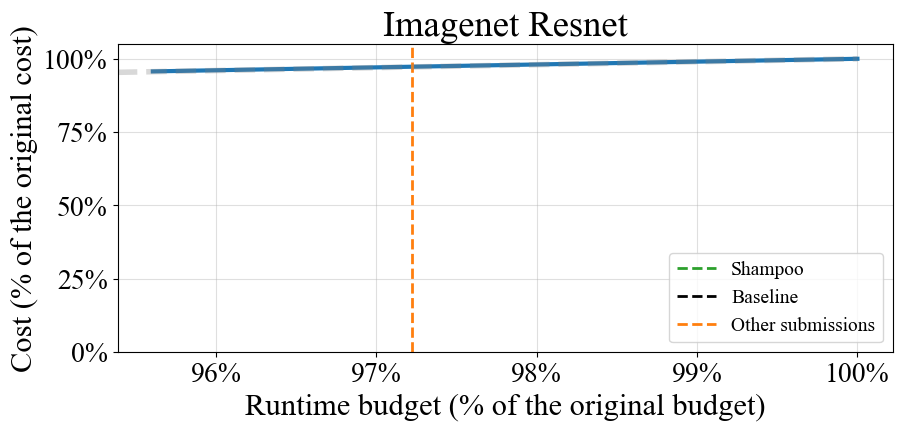

In [181]:
def compute_sum_capped(group, cap_budget, runtime_budget):
    # Sum the compute_time column
    # but replace values greater than max_budget with max_budget
    group["computation_time"] = group["time_to_target"].replace(
        [np.inf], runtime_budget
    )
    raw_compute_time = group["computation_time"].sum()
    group["computation_time"] = group["computation_time"].clip(upper=cap_budget)
    clipped_compute_time = group["computation_time"].sum()
    relative_clipped_compute_time = clipped_compute_time / raw_compute_time
    return relative_clipped_compute_time

# Groupby workload
for workload, group in clean_results_df.groupby(["workload"]):
    if workload[0] == "imagenet_resnet":
        runtime_budget = group["runtime_budget"].mean()
        # Sum the time_to_target column
        # if inf, then replace with the runtime_budget value
        group["computation_time"] = group["time_to_target"].replace(
            [np.inf], runtime_budget
        )
        compute_time = group["computation_time"].sum()

        # Minimal compute time (lower bound) is min of computation_time column * 11 * 5 * 5
        min_compute_time = group["computation_time"].min() * 11 * 5 * 5
        # Maximal compute time (upper bound) is runtime_budget * 11 * 5 * 5
        max_compute_time = group["runtime_budget"].sum()

        # print(f"Total computation time in seconds: {compute_time:,.0f}")
        # print(f"Minimal compute time in seconds: {min_compute_time:,.0f}")
        # print(f"Maximal compute time in seconds: {max_compute_time:,.0f}")

        # Compute the total costs for different budgets
        num_budgets = 100
        budgets = np.linspace(runtime_budget, group["computation_time"].min(), num_budgets)
        costs = np.zeros(num_budgets)
        for i, cap_budget in enumerate(budgets):
            relative_budget = cap_budget / runtime_budget

            clipped_compute_time = compute_sum_capped(group, cap_budget, runtime_budget)
            costs[i] = clipped_compute_time
            # print(f"Maximal budget: {relative_budget:.2f} (i.e. capped at {cap_budget:,.0f} seconds) and compute time sum: {clipped_compute_time:,.0f}")

        # Normalize the budgets
        budgets = budgets / runtime_budget

        # Plot the costs
        plt.figure(figsize=(10, 4))
        plt.plot(budgets, costs)
        plt.xlabel("Runtime budget (% of the original budget)")
        plt.ylabel("Cost (% of the original cost)")
        plt.title(f"{workload[0].replace('_', ' ').title()}")
        # Plot y axis as percentage
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.0%}"))
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x:.0%}"))
        plt.ylim(0, 1.05)

        # Plot the runtimes of the submissions as vertical lines
        # add the names of the submissions as text labels
        sub_runtimes = runtimes_base.transpose()[workload[0]].to_list()
        sub_runtimes = sub_runtimes / runtime_budget
        for idx, sub_runtime in enumerate(sub_runtimes):
            sub_name = runtimes_base.transpose().index[idx]
            if sub_name == "shampoo_submission" and not SELF_TUNING:
                color = sns.color_palette()[2]
            elif sub_name == "schedule_free_adamw" and SELF_TUNING:
                color = sns.color_palette()[2]
            elif sub_name == "prize_qualification_baseline":
                color = "black"
            else:
                color = sns.color_palette()[1]

            plt.axvline(x=sub_runtime, color=color, linestyle="--", linewidth=2)

        # Save current limits
        y_lim = plt.gca().get_ylim()
        x_lim = plt.gca().get_xlim()
        # Add a thin line at the identity, i.e. x = y
        plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=4, alpha=0.3)
        # Restore the original limits
        plt.gca().set_ylim(y_lim)
        plt.gca().set_xlim(x_lim)

        # Manually fill the legend only with the vertical lines
        plt.legend(
            [
                plt.Line2D([0], [0], color=color, linestyle="--", linewidth=2)
                for color in [sns.color_palette()[2], "black", sns.color_palette()[1]]
            ],
            ["Shampoo", "Baseline", "Other submissions"],
            loc="lower right",
            fontsize=14,
        )
        plt.savefig(f"plots/compute_budgets_{workload[0]}.png", bbox_inches="tight")
        plt.show()


In [180]:
# Get the index where the value of budget is closest to 0.95
def saved_compute(cap, budgets, costs):
    # Index of the budget that is closest to the cap
    idx = np.argmin(np.abs(budgets - cap))
    return 1-costs[idx]
    
cap = 0.80
saved_comp = saved_compute(cap, budgets, costs)
print(f"The saved compute when capping at {cap:.0%} of the original budget is roughly {saved_comp:.0%}")

The saved compute when capping at 80% of the original budget is roughly 14%


In [144]:
# Only show workload and submission
sub = "generalized_adam"
workload = "criteo1tb"
workload_sub_df = clean_results_dict[sub][clean_results_dict[sub]["workload"] == workload]

# Compute the fastest time_to_target per study
fastest_time_to_target = workload_sub_df.groupby("study")["time_to_target"].min()
fastest_time_to_target = fastest_time_to_target / runtime_budget
print(fastest_time_to_target.tolist())
print(fastest_time_to_target.median())

[0.7219709234548423, 0.8934783969283894, 0.8312157814214559, 0.8465056450633466, 0.8000140290716539]
0.8312157814214559
